In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

Using the manual ZP file ... .


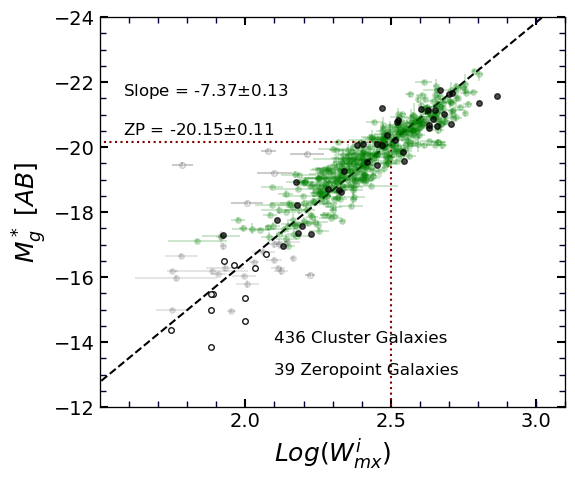

In [4]:
band = 'g'

ctl   = np.genfromtxt('allzpa_labels.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dm19']-25)/5)  
manualInput_all = (PGC,ID,dist)

ctl   = np.genfromtxt('TFcal_ZP_trgb2.81.rizzi.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dmtriz']-25)/5) 
manualInput_rizzi = (PGC,ID,dist)



ctl   = np.genfromtxt('TFcal_ZP_cepheids2.33.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dmc19']-25)/5) 
manualInput_cepheids = (PGC,ID,dist)


manualInput = manualInput_all

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = False,
                                            manualInput=manualInput
                                           )

In [5]:
slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

print S_ZP

Clusters_orig = allCluster(table, band=band, pgcFaint=I_maglim)

[-7.370193787547213 0.1313945629400118 -20.148567275189283
 array([0.107156])]


[5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590, 37700]
[3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073, 3974, 19871, 22277, 38148, 41020, 41093, 46127]


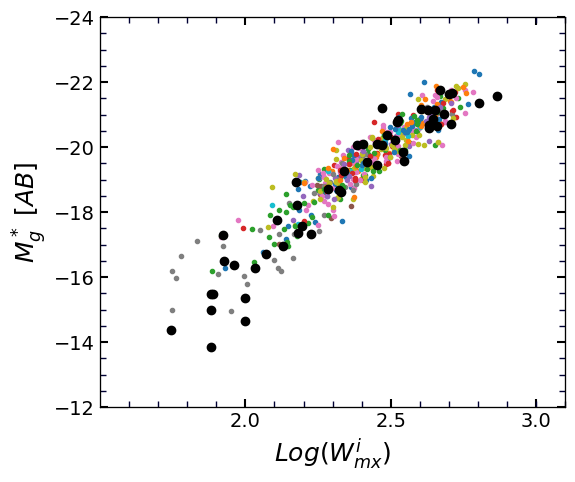

In [6]:
fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)

# I_maglim = []

for i, key in enumerate(Clusters):
    myCluster = Clusters[key]
    zp_ = myCluster['zp']
    zp    = zp_calibs['zp']
    pgc = myCluster['pgc']
    pgc_w = myCluster['pgc_w']
    mag_      = myCluster['mag']
    mag_w     = myCluster['mag_w']
    logWimx_  = myCluster['logWimx']
    offset=zp_-zp
    ax.errorbar(logWimx_, mag_-offset, fmt='.')
    
    for i, idd in enumerate(pgc):
        m = mag_[i]
        if m-offset > -17.:
            if not pgc[i] in I_maglim:
                I_maglim.append(pgc[i])
    for i, idd in enumerate(pgc_w):
        m = mag_w[i]
        if m-offset > -17.:
            if not pgc_w[i] in I_maglim:
                I_maglim.append(pgc_w[i])
                
print I_maglim


# calib_maglim = []
pgc = zp_calibs['pgc']
pgc_w = zp_calibs['pgc_w']
mag_      = zp_calibs['MAG']
mag_w     = zp_calibs['MAG_w']
logWimx_  = zp_calibs['logWimx']
ax.errorbar(logWimx_, mag_, fmt='o', color='black')

for i, idd in enumerate(pgc):
    m = mag_[i]
    if m > -16.1:
        if not pgc[i] in I_maglim:
            calib_maglim.append(pgc[i])
for i, idd in enumerate(pgc_w):
    m = mag_w[i]
    if m > -16.1:
        if not pgc_w[i] in I_maglim:
            calib_maglim.append(pgc_w[i])
            
print calib_maglim

In [7]:
d_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        print key, myCluster['slope'], myCluster['zp'], Clusters_orig[key]['zp']-zp, Clusters_orig[key]['name']
        
        d_modulus = Clusters_orig[key]['zp']-zp
        d_lst.append(d_modulus)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

for i in indx:
    key = keys[i]
    print key, '%.1f'%d_lst[i], Clusters_orig[key]['name']

NEST_200092 -7.370193787547213 13.157038834676863 33.16606522260307 Pegasus
NEST_200037 -7.370193787547213 14.405305546200355 34.64317336099483 NGC70
NEST_200005 -7.370193787547213 13.81552154112348 33.975764388241785 NGC410
NEST_200006 -7.370193787547213 13.773912297630341 33.919330888149894 NGC507
NEST_200012 -7.370193787547213 14.559982446845774 34.69671862149741 Abell 400
NEST_200003 -7.370193787547213 13.486006672651353 33.8696205639412 Abell 262
NEST_100001 -7.370193787547213 14.520840792519007 34.66752145717666 Coma
NEST_100002 -7.370193787547213 10.793946284099707 31.016188951635893 Virgo
NEST_100005 -7.370193787547213 14.487931928689969 34.62848989260763 Abell 1367
NEST_200045 -7.370193787547213 14.410373725120955 34.58705387412287 NGC80
NEST_100007 -7.370193787547213 15.611913493384634 35.77940953214984 Abell 2151 (Hercules)
NEST_200016 -7.370193787547213 15.086181063044323 35.26372986159347 Abell 2634/66
NEST_100008 -7.370193787547213 11.19050026679688 31.323646099654866 Urs

In [8]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    rms = np.sqrt(np.mean((mag-mag_fit)**2))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS
    

Virgo (24) -6.70 0.46 10.87 0.09 10.79 0.09 0.58


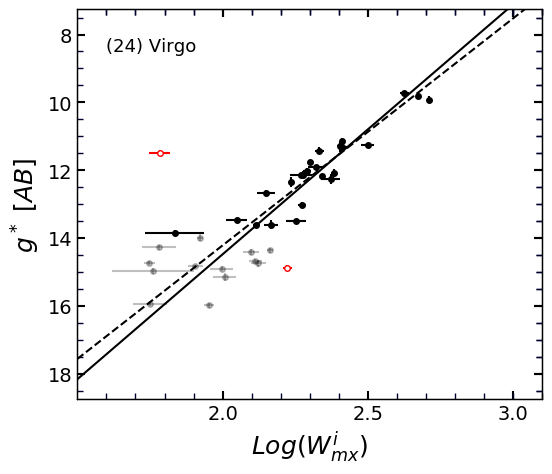

In [9]:
##########################################
def plotSingleCluster(key, xLim = (1.5,3.1), yLim = (18.75,7.25)):
#         key = 'NEST_100002'
    logWimx_, mag_, logWimx_e_, mag_e_ = plotCluster(ax, Clusters, nest=key, plotErrors=True, alpha=1., 
                        markersize=0, pgcFaint=I_maglim, plotWeird=True, color='k', 
                        alphaFaint=0.25, weirdColor='r', alphaWeird=1.)
    
    ## solid line, universal fit
    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+Clusters[key]['zp']
    ax.plot(x,y, 'k-')  
    
    
    ## dashed line, original fit
    y = Clusters_orig[key]['slope']*(x-2.5)+Clusters_orig[key]['zp']
    ax.plot(x,y, 'k--')  
    
    
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    ZPorig = Clusters_orig[key]['zp']
    ZPorig_e = Clusters_orig[key]['zp_e']
    Zp_univ = Clusters[key]['zp']
    Zp_univ_e = Clusters[key]['zp_e']
    rms, RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, Zp_univ)
    print Clusters_orig[key]['name'], '(%d)'%len(logWimx_), '%.2f'%Sorig, '%.2f'%Sorig_e, '%.2f'%ZPorig, '%.2f'%ZPorig_e, '%.2f'%Zp_univ, '%.2f'%Zp_univ_e, '%.2f'%rms
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_xticks(np.arange(2, 3.5, step=0.5))
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')   
        x_ax.set_xticks(np.arange(2, 3.5, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    ax.text(1.6,8.5, r''+"(%d)" % len(logWimx_)+' '+Clusters[key]['name'], fontsize=13)
    
##########################################    
    
    

fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (18.75,7.25))
plotSingleCluster('NEST_100002')

Virgo (24) -6.70 0.46 10.87 0.09 10.79 0.09 0.58
Ursa Major (35) -7.62 0.50 11.18 0.08 11.19 0.07 0.50
Pegasus (24) -8.19 1.19 13.02 0.24 13.16 0.11 0.56
Abell 262 (6) -5.58 1.60 13.72 0.28 13.49 0.23 0.66
NGC507 (20) -6.68 0.61 13.77 0.10 13.77 0.11 0.49
NGC410 (33) -6.82 0.50 13.83 0.07 13.82 0.07 0.49
Cancer (18) -6.84 0.72 13.92 0.10 13.93 0.10 0.44
NGC80 (14) -6.03 0.54 14.44 0.06 14.41 0.08 0.42
Abell 1367 (68) -7.65 0.46 14.48 0.06 14.49 0.06 0.53
NGC70 (11) -8.67 1.43 14.49 0.16 14.41 0.11 0.36
Coma (79) -7.50 0.40 14.52 0.06 14.52 0.06 0.57
Abell 400 (21) -6.43 0.48 14.55 0.06 14.56 0.07 0.51
NGC4065 (14) -7.18 0.45 14.87 0.08 14.86 0.07 0.34
Abell 2634/66 (29) -7.71 0.69 15.12 0.09 15.09 0.07 0.46
Abell 2151 (Hercules) (39) -7.62 0.53 15.63 0.08 15.61 0.06 0.43


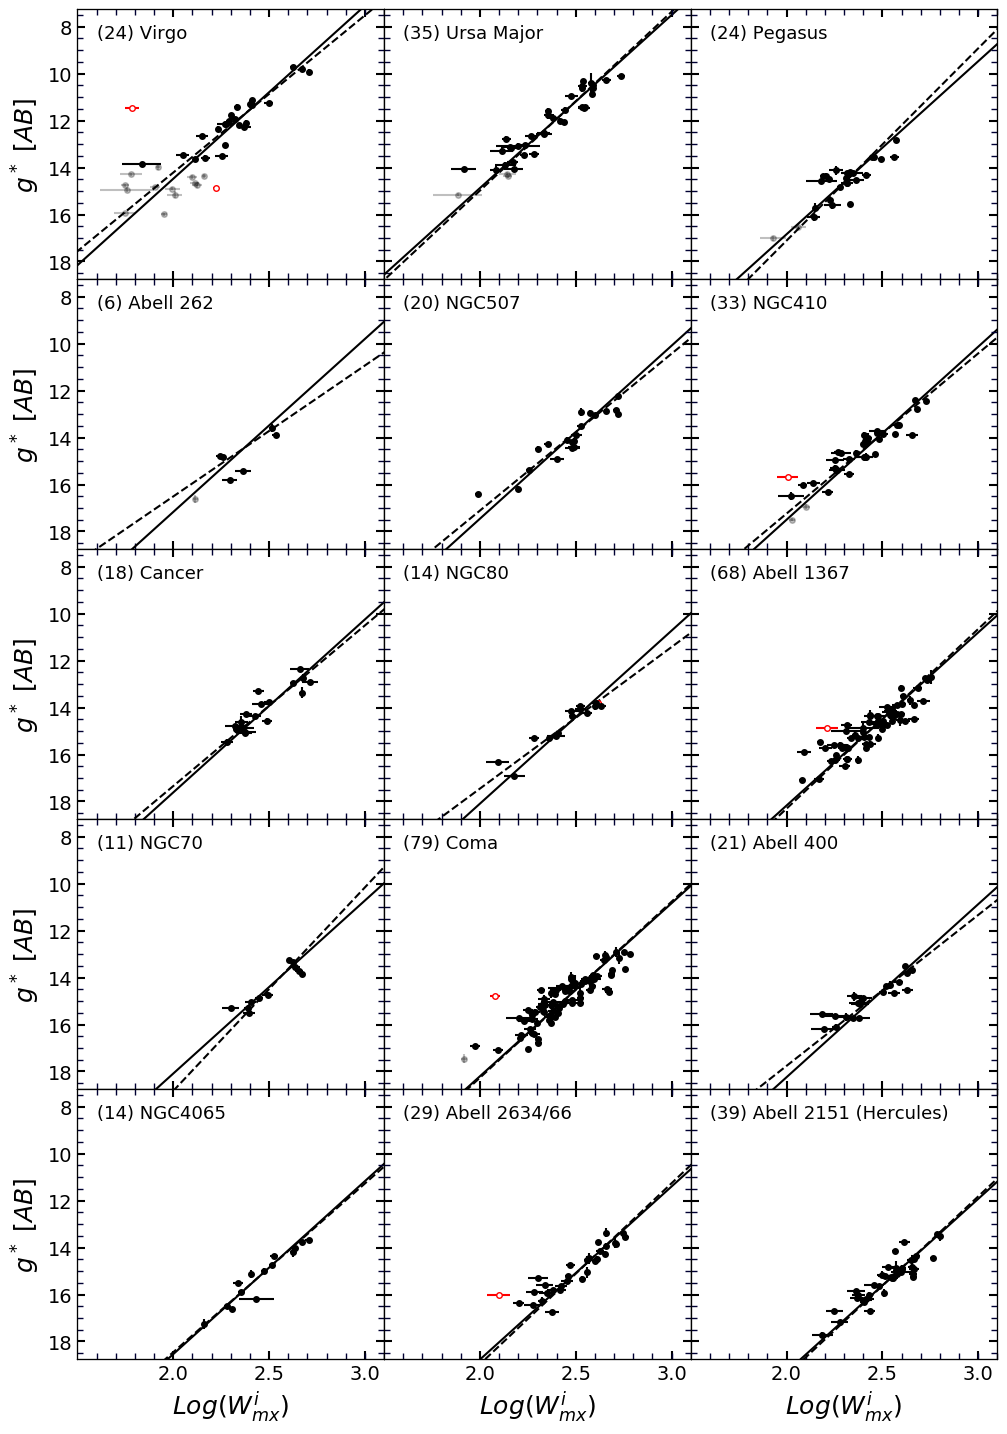

In [10]:
fig = py.figure(figsize=(10, 15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(5, 3); p=0


for i in indx:
    key = keys[i]
    ax = plt.subplot(gs[p])
    plotSingleCluster(key)
    
    if p%3==0: 
        ax.set_ylabel(r'$'+band+'^* \/\/ [AB]$', fontsize=18)
    else:
        plt.setp(ax.get_yticklabels(), visible=False) 
        
    if p>11: ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    p+=1

plt.subplots_adjust(hspace=.0, wspace=0)

In [11]:
myKeys = ['NEST_100002', 'NEST_100008', 'NEST_200092',  'NEST_200003', 'NEST_200005', 'NEST_200006', 'NEST_100030', 'NEST_200045', 'NEST_200037', 'NEST_100005', 'NEST_100001', 'NEST_200012', 'NEST_100018', 'NEST_200016', 'NEST_100007']

for key in myKeys:
    myCluster = Clusters[key]
    
    mag = myCluster['mag']
    pgc = myCluster['pgc']
    ix = []
    for i, id in enumerate(pgc):
        if not id in I_maglim:
            ix.append(i)  
    
    mags = mag[ix]
    jj = np.argsort(mags)
    
    print mags[jj][::-1][1]
    

    

13.63
14.08
15.72
15.44
16.31
16.19
15.08
16.33
15.28
17.04
17.06
16.11
16.6
16.45
17.15


Using the manual ZP file ... .


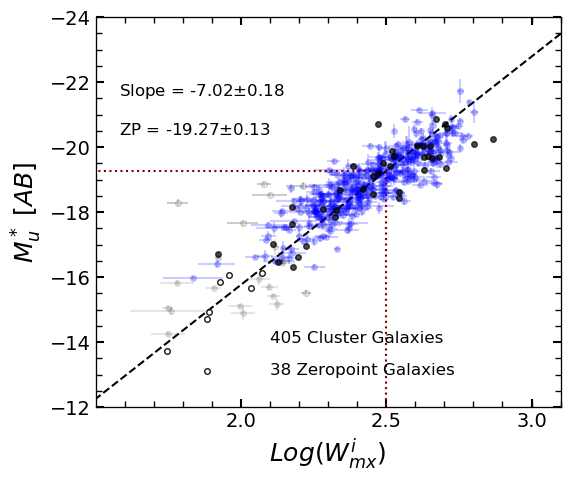

In [12]:
band = 'u'

fig, ax, u_Clusters, S_ZP, u_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


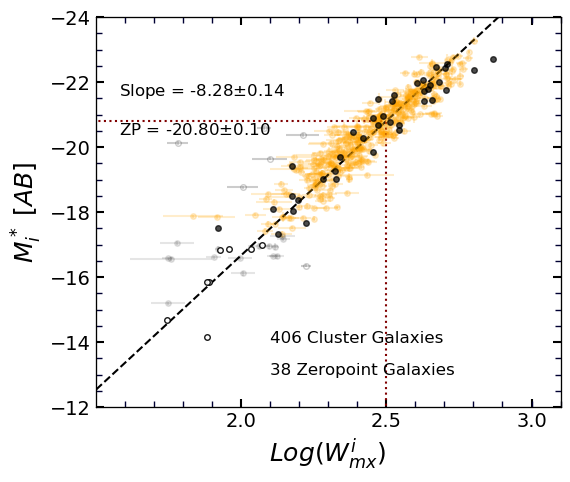

In [13]:
band = 'i'

fig, ax, i_Clusters, S_ZP, i_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


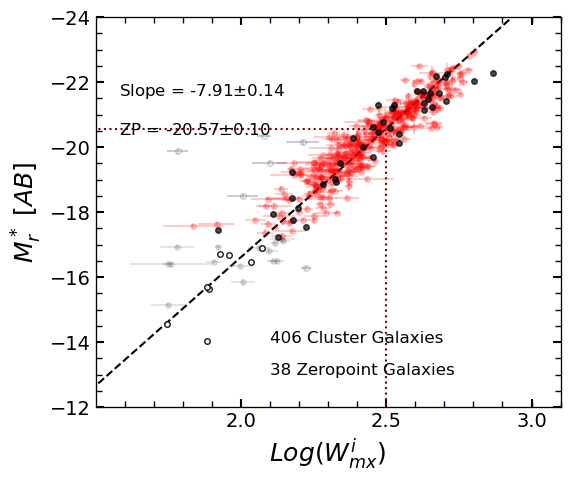

In [14]:
band = 'r'

fig, ax, r_Clusters, S_ZP, r_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


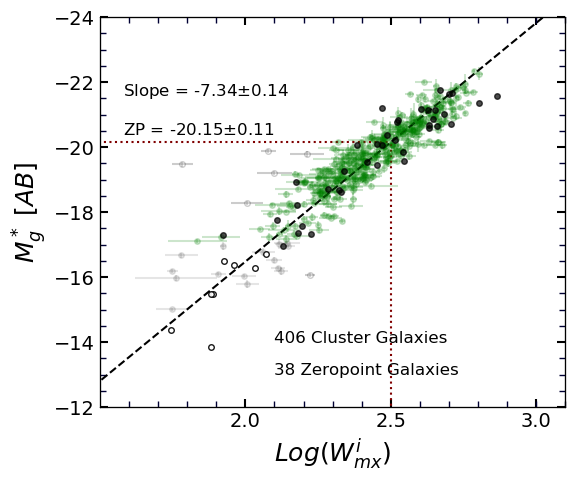

In [15]:
band = 'g'

fig, ax, g_Clusters, S_ZP, g_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


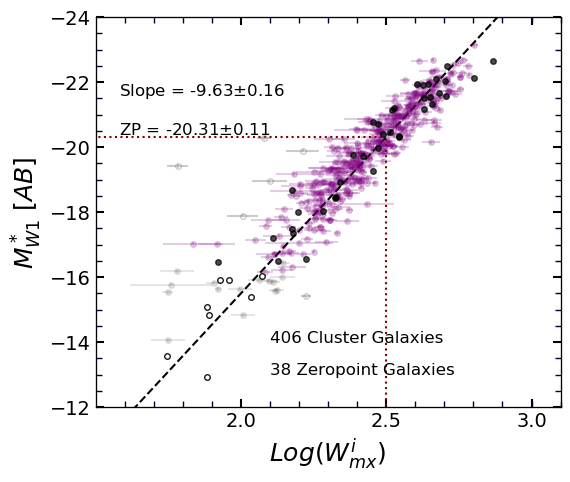

In [16]:
band = 'w1'

fig, ax, w1_Clusters, S_ZP, w1_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


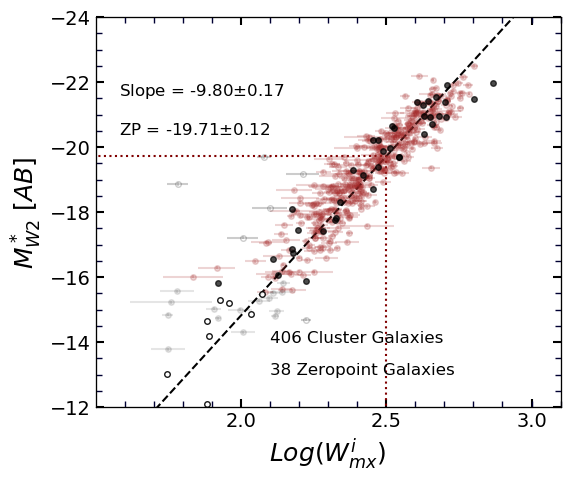

In [17]:
band = 'w2'

fig, ax, w2_Clusters, S_ZP, w2_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

Using the manual ZP file ... .


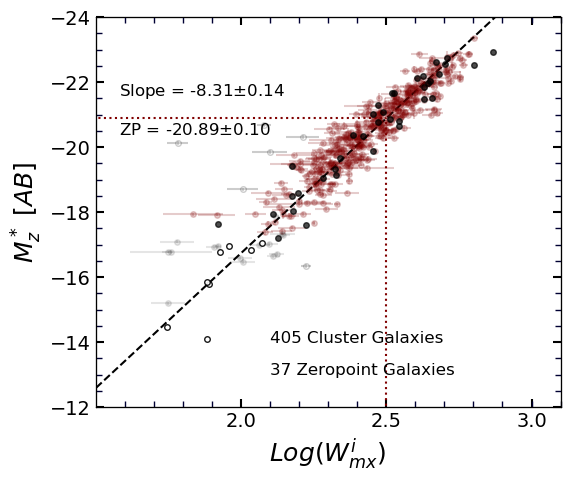

In [18]:
band = 'z'

fig, ax, z_Clusters, S_ZP, z_zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = True,
                                            manualInput=manualInput
                                           )

In [19]:
colorD = {}
for key in w1_Clusters:
    
    cluster = w1_Clusters[key]
    d_modulus = cluster['zp']-w1_zp_calibs['zp']
    
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd] = {}
        colorD[idd]['w1'] = cluster['mag'][j]
        colorD[idd]['logWimx'] = cluster['logWimx'][j]
        colorD[idd]['Mw1'] = cluster['mag'][j]-d_modulus
        
        
    
for key in i_Clusters:
    
    cluster = i_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['i'] = cluster['mag'][j]
        
for key in g_Clusters:
    
    cluster = g_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['g'] = cluster['mag'][j]  
        
for key in w2_Clusters:
    
    cluster = w2_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['w2'] = cluster['mag'][j]          

        
for key in z_Clusters:
    
    cluster = z_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['z'] = cluster['mag'][j]         

for key in r_Clusters:
    
    cluster = r_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['r'] = cluster['mag'][j]  
        
for key in u_Clusters:
    
    cluster = u_Clusters[key]
    for j, idd in enumerate(cluster['pgc']):
        colorD[idd]['u'] = cluster['mag'][j]  
        
################################################
colorZ = {}

cluster = w1_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd] = {}
    colorZ[idd]['w1'] = cluster['mag'][j]
    colorZ[idd]['Mw1'] = cluster['MAG'][j]
    colorZ[idd]['logWimx'] = cluster['logWimx'][j]

cluster = i_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['i'] = cluster['mag'][j]

cluster = g_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['g'] = cluster['mag'][j]    

cluster = w2_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['w2'] = cluster['mag'][j]   
    
cluster = z_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['z'] = cluster['mag'][j]  
    
cluster = r_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['r'] = cluster['mag'][j]  
        
cluster = u_zp_calibs
for j, idd in enumerate(cluster['pgc']):
    colorZ[idd]['u'] = cluster['mag'][j]  

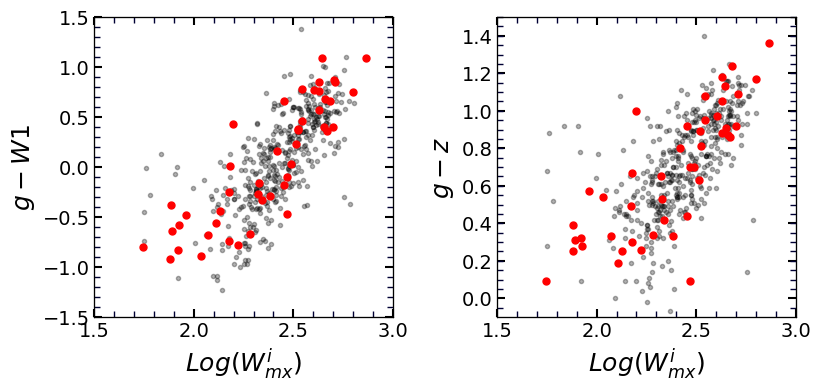

In [20]:
fig = py.figure(figsize=(12, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0

##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    i_w1 = colorD[key]['g']-colorD[key]['w1']
    ax.plot(logW, i_w1, 'k.', alpha=0.3)
    C_col.append(i_w1)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    i_w1 = colorZ[key]['g']-colorZ[key]['w1']
    ax.plot(logW, i_w1, 'r.', ms=10)
    Z_col.append(i_w1)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
ax.set_ylabel(r'$g-W1$', fontsize=18)

xLim= [1.5,3]
yLim= [-1.5,1.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(1.5, 3.5, step=0.5))

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
    x_ax.set_xticks(np.arange(1.5, 3.5, step=0.5))


for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['g']-colorD[key]['z']
        ax.plot(logW, i_w1, 'k.', alpha=0.3)
        C_col.append(i_w1)
    except:
        pass

Z_col = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['g']-colorZ[key]['z']
        ax.plot(logW, i_w1, 'r.', ms=10)
        Z_col.append(i_w1)
    except:
        pass

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
ax.set_ylabel(r'$g-z$', fontsize=18)

xLim= [1.5,3]
yLim= [-0.1,1.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(1.5, 3.5, step=0.5))

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
    x_ax.set_xticks(np.arange(1.5, 3.5, step=0.5))


for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
plt.subplots_adjust(hspace=0, wspace=0.35)

-0.53 -0.57


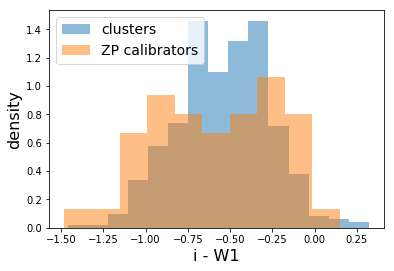

In [21]:
C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    i_w1 = colorD[key]['i']-colorD[key]['w1']
    ax.plot(logW, i_w1, 'k.', alpha=0.3)
    C_col.append(i_w1)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    i_w1 = colorZ[key]['i']-colorZ[key]['w1']
    ax.plot(logW, i_w1, 'r.', ms=10)
    Z_col.append(i_w1)

plt.hist(C_col, bins=15, alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=10, alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('i - W1', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

0.10 0.02


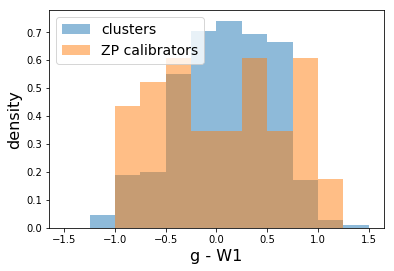

In [22]:
C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    g_w1 = colorD[key]['g']-colorD[key]['w1']
    C_col.append(g_w1)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    g_w1 = colorZ[key]['g']-colorZ[key]['w1']
    Z_col.append(g_w1)
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=np.linspace(-1.5,1.5,13), alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=np.linspace(-1.5,1.5,13), alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('g - W1', fontsize=16)
plt.ylabel('density', fontsize=16)


print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

0.62 0.60


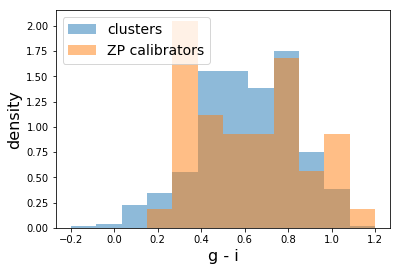

In [23]:
C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    g_i = colorD[key]['g']-colorD[key]['i']
    C_col.append(g_i)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    g_i = colorZ[key]['g']-colorZ[key]['i']
    Z_col.append(g_i)
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=np.linspace(-0.2,1.2,13), alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=np.linspace(-0.2,1.2,13), alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('g - i', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

0.72 0.67


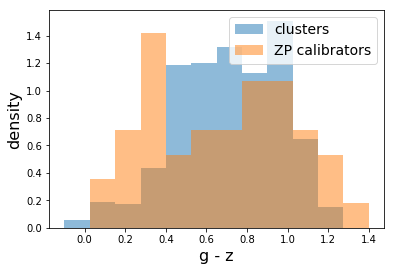

In [24]:
C_col = []
for key in colorD:
    try: 
        logW = colorD[key]['logWimx']
        g_z = colorD[key]['g']-colorD[key]['z']
        C_col.append(g_z)
    except:
        pass

Z_col = []
for key in colorZ:
    try: 
        logW = colorZ[key]['logWimx']
        g_z = colorZ[key]['g']-colorZ[key]['z']
        Z_col.append(g_z)
    except:
        pass
    
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=np.linspace(-0.1,1.4,13), alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=np.linspace(-0.1,1.4,13), alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('g - z', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

-0.58 -0.61


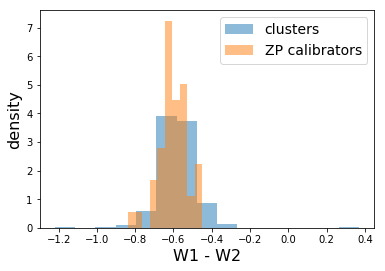

In [25]:
C_col = []
for key in colorD:
    logW = colorD[key]['logWimx']
    w1_w2 = colorD[key]['w1']-colorD[key]['w2']
    C_col.append(w1_w2)

Z_col = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    w1_w2 = colorZ[key]['w1']-colorZ[key]['w2']
    Z_col.append(w1_w2)
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=15, alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=10, alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('W1 - W2', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

# print len(C_col), len(Z_col)
# print Z_col
# print C_col[0:10]

-0.63 -0.62


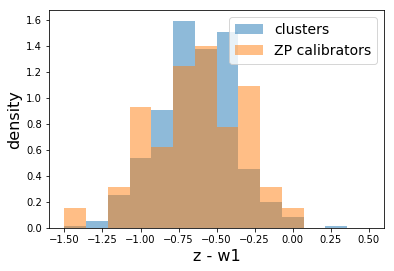

In [26]:
C_col = []
for key in colorD:
    try: 
        logW = colorD[key]['logWimx']
        g_z = colorD[key]['z']-colorD[key]['w1']
        C_col.append(g_z)
    except:
        pass

Z_col = []
for key in colorZ:
    try: 
        logW = colorZ[key]['logWimx']
        g_z = colorZ[key]['z']-colorZ[key]['w1']
        Z_col.append(g_z)
    except:
        pass
    
    
C_col = np.asarray(C_col)
Z_col = np.asarray(Z_col)

plt.hist(C_col, bins=np.linspace(-1.5,0.5,15), alpha=0.5, density=True, label='clusters')
plt.hist(Z_col, bins=np.linspace(-1.5,0.5,15), alpha=0.5, density=True, label='ZP calibrators')

plt.legend(fontsize=14)
plt.xlabel('z - w1', fontsize=16)
plt.ylabel('density', fontsize=16)

print '%.2f'%np.median(C_col), '%.2f'%np.median(Z_col)

[[0.00018188 0.00359569]
 [0.00359569 0.07157311]]
-5.189284927178579 0.2675315184860639
-5.048375709508729 0.06961905772163988
0.14090921766984987 0.2764415427925191
[[7.44745530e-05 1.47230293e-03]
 [1.47230293e-03 2.93062657e-02]]
-4.343577228741976 0.17119072888155976
-4.235845254727059 0.045306041458581456
0.10773197401491696 0.17708445173884238
[[3.83000989e-05 7.57162616e-04]
 [7.57162616e-04 1.50713608e-02]]
-3.5623672799551116 0.12276547066095343
-3.4857985501282887 0.03150476703658841
0.07656872982682295 0.12674348556290824
[[2.61032804e-05 5.16041175e-04]
 [5.16041175e-04 1.02718261e-02]]
-3.118767181127292 0.10135001756424777
-3.0761806070345648 0.02710177995055626
0.04258657409272715 0.1049110696578855
[[2.79328989e-05 5.52088439e-04]
 [5.52088439e-04 1.09868886e-02]]
-3.0453628521569955 0.10481835989495333
-2.968618278388005 0.027097209188757524
0.07674457376899069 0.10826424763922411


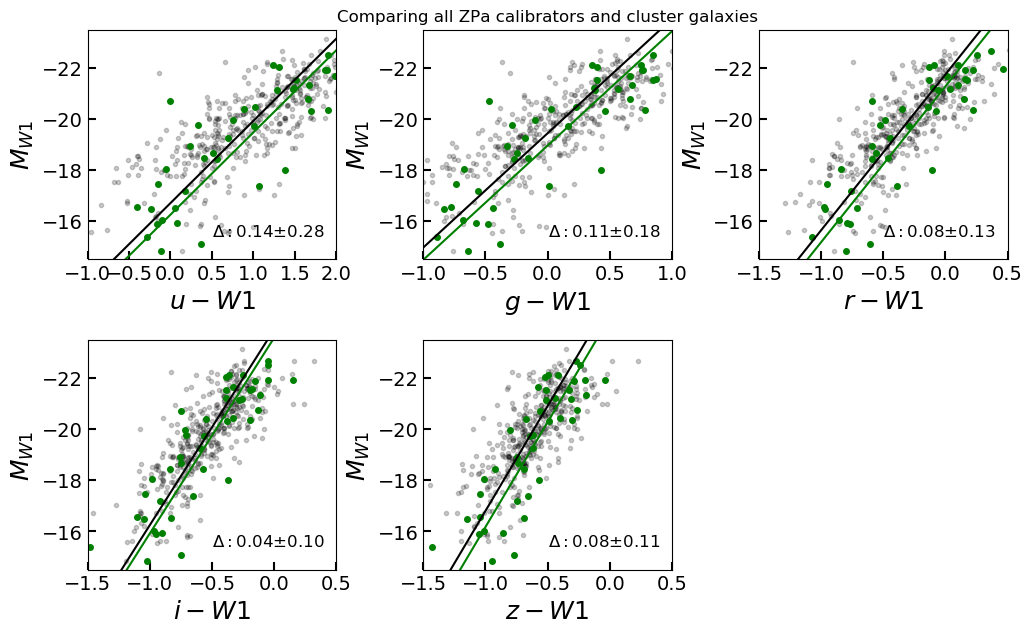

In [33]:
fig = py.figure(figsize=(10, 6), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(2, 3); p=0

##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['u']-colorD[key]['w1']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['u']-colorZ[key]['w1']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, '-', color='k')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '-', color='g')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$u-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.0,2.0]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1., 2.5, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['g']-colorD[key]['w1']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['g']-colorZ[key]['w1']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass

    
C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, '-', color='k')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '-', color='g')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e

ax.set_xlabel(r'$g-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.,1.]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1., 1.5, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
plt.title("Comparing all ZPa calibrators and cluster galaxies")
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['r']-colorD[key]['w1']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['r']-colorZ[key]['w1']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass

    
C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, '-', color='k')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '-', color='g')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e

ax.set_xlabel(r'$r-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    logW = colorD[key]['logWimx']
    i_w1 = colorD[key]['i']-colorD[key]['w1']
    ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
    C_col.append(i_w1)
    C_w.append(colorD[key]['Mw1'])

Z_col = []
Z_w = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    i_w1 = colorZ[key]['i']-colorZ[key]['w1']
    ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
    Z_col.append(i_w1)
    Z_w.append(colorZ[key]['Mw1'])


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, '-', color='k')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '-', color='g')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$i-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1.0, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['z']-colorD[key]['w1']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='k')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['z']-colorZ[key]['w1']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'g.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, '-', color='black')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '-', color='green')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$z-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1.0, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################



plt.subplots_adjust(hspace=0.35, wspace=0.35)



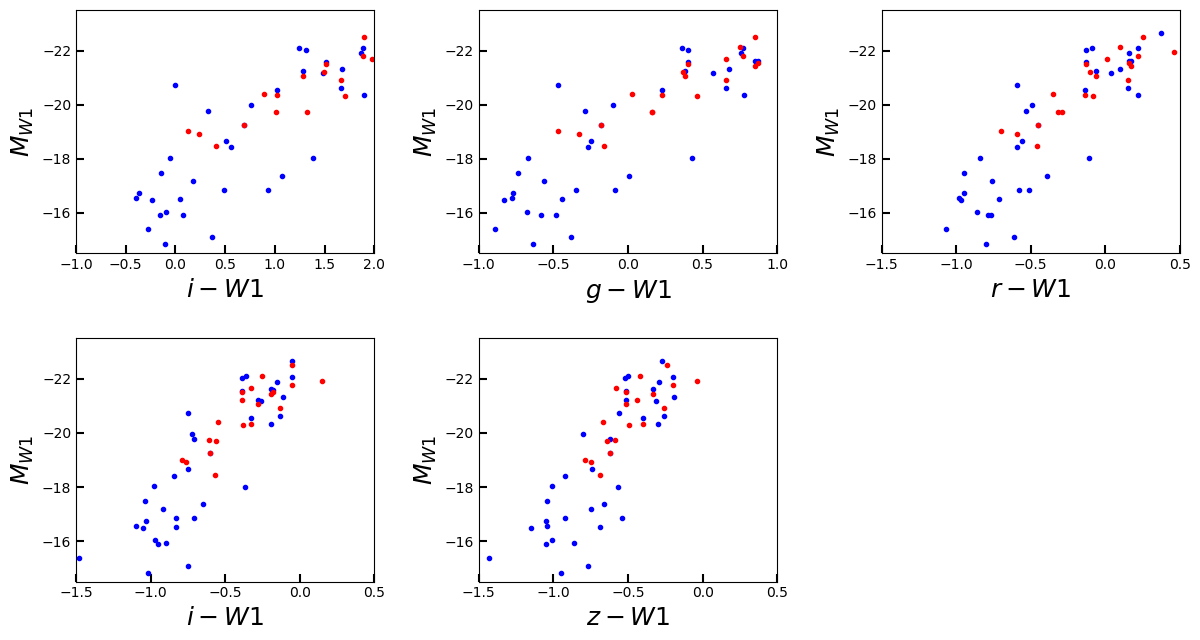

In [28]:
fig = py.figure(figsize=(12, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0
ax = plt.subplot(gs[p]); p+=1 


ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
u    = ctl['u']
W1   = ctl['W1']

indx, = np.where(u>0)
u = u[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
u = u[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(u-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
u    = ctl['u']
W1   = ctl['W1'] 
indx, = np.where(u>0)
u = u[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
u = u[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(u-W1, W1-DM, 'r.')


ax.set_xlabel(r'$i-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.0,2.0]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')


########################################################################################

ax = plt.subplot(gs[p]); p+=1 



ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
g    = ctl['g']
W1   = ctl['W1']

indx, = np.where(g>0)
g = g[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
g = g[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(g-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
g    = ctl['g']
W1   = ctl['W1'] 
indx, = np.where(g>0)
g = g[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
g = g[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(g-W1, W1-DM, 'r.')


ax.set_xlabel(r'$g-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.,1.]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
########################################################################################

ax = plt.subplot(gs[p]); p+=1 

ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
r    = ctl['r']
W1   = ctl['W1']

indx, = np.where(r>0)
r = r[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
r = r[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(r-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
r    = ctl['r']
W1   = ctl['W1'] 
indx, = np.where(r>0)
r = r[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
r = r[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(r-W1, W1-DM, 'r.')


ax.set_xlabel(r'$r-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
########################################################################################
ax = plt.subplot(gs[p]); p+=1 

ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
i    = ctl['i']
W1   = ctl['W1']

indx, = np.where(i>0)
i = i[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
i = i[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(i-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
i    = ctl['i']
W1   = ctl['W1'] 
indx, = np.where(i>0)
i = i[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
i = i[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(i-W1, W1-DM, 'r.')


ax.set_xlabel(r'$i-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
########################################################################################

ax = plt.subplot(gs[p]); p+=1 
ctl   = np.genfromtxt('TFcal_parameters_trgb.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['dmt']
z    = ctl['z']
W1   = ctl['W1']

indx, = np.where(z>0)
z = z[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
z = z[indx]
W1 = W1[indx]
DM = DM[indx]
ax.plot(z-W1, W1-DM, 'b.')




ctl   = np.genfromtxt('TFcal_parameters_cepheids.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
DM   = ctl['DMc19']
z    = ctl['z']
W1   = ctl['W1'] 
indx, = np.where(z>0)
z = z[indx]
W1 = W1[indx]
DM = DM[indx]
indx, = np.where(W1>0)
z = z[indx]
W1 = W1[indx]
DM = DM[indx]

ax.plot(z-W1, W1-DM, 'r.')


ax.set_xlabel(r'$z-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
##############################################################################################

plt.subplots_adjust(hspace=0.35, wspace=0.35)


[[2.79328989e-05 5.52088439e-04]
 [5.52088439e-04 1.09868886e-02]]
-3.0453628521569955 0.10481835989495333
-3.016002579631257 0.026394906763373378


Text(-0.5,-15.4,'$\\Delta:$0.03$\\pm$0.11')

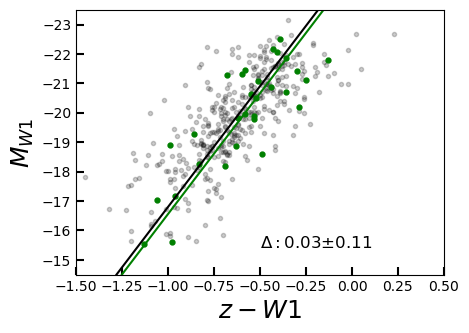

In [29]:
fig = py.figure(figsize=(12, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0
ax = plt.subplot(gs[p]); p+=1 

ax.plot(C_col, C_w, 'k.', alpha=0.2)
# ax.plot(Z_col, Z_w, 'b.', ms=7)

N = len(C_col)

indx = np.arange(N)
np.random.shuffle(indx)

indx = indx[0:30]

ax.plot(C_col[indx], C_w[indx], 'g.', ms=7)



Z_col = C_col[indx]
Z_w = C_w[indx]
fit, cov = curve_fit(linfit, C_w, C_col)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, '-', color='black')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, '-', color='green')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)



ax.set_xlabel(r'$z-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')


[[0.00011038 0.00218214]
 [0.00218214 0.04343614]]
-2.070263804792962 0.20841338929749975
-1.9723259928413728 0.05111376323990561
0.09793781195158902 0.21458974260438524
[[2.43302842e-05 4.80990448e-04]
 [4.80990448e-04 9.57413967e-03]]
-1.22481003769216 0.09784753277974155
-1.1596646380785107 0.024756179544706266
0.06514539961364929 0.10093070938387548
[[4.04395752e-06 7.99458365e-05]
 [7.99458365e-05 1.59132598e-03]]
-0.44360005698268157 0.0398914273740303
-0.4096179042816863 0.011641554510224618
0.03398215270099525 0.04155540601837582
[[2.61032804e-05 5.16041175e-04]
 [5.16041175e-04 1.02718261e-02]]
-3.118767181127292 0.10135001756424777
-3.0761806070345648 0.02710177995055626
0.04258657409272715 0.1049110696578855
[[6.84717287e-06 1.35333070e-04]
 [1.35333070e-04 2.69320864e-03]]
0.07104246575254201 0.05189613317868593
0.10693323221328611 0.014783479242650409
0.0358907664607441 0.053960725508630646


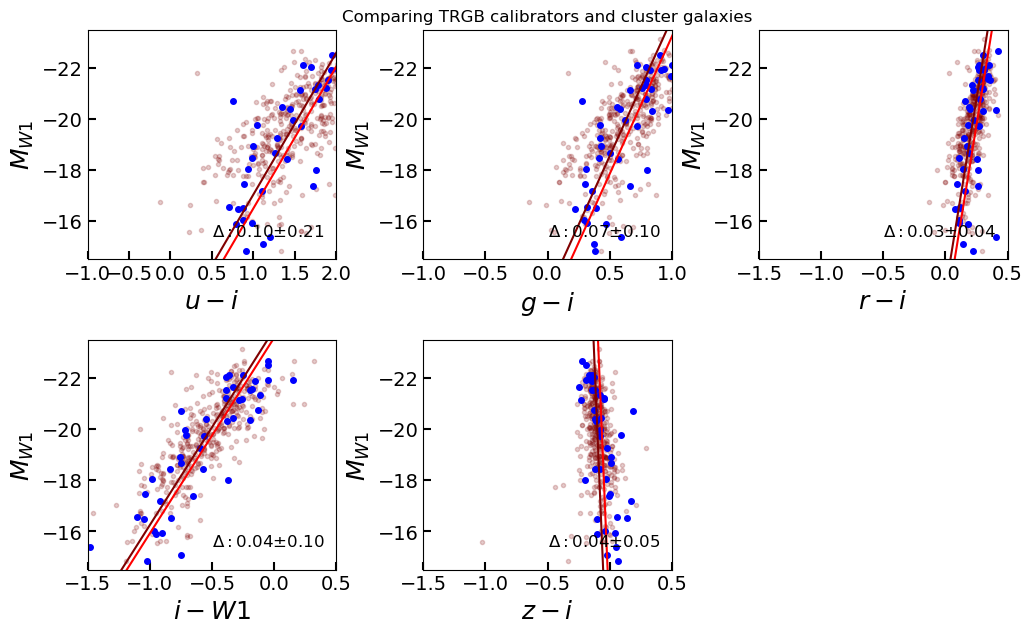

In [30]:
fig = py.figure(figsize=(10, 6), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(2, 3); p=0

##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['u']-colorD[key]['i']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['u']-colorZ[key]['i']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$u-i$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.0,2.0]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1., 2.5, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['g']-colorD[key]['i']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['g']-colorZ[key]['i']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass

    
C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e

ax.set_xlabel(r'$g-i$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.,1.]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1., 1.5, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
plt.title("Comparing TRGB calibrators and cluster galaxies")
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['r']-colorD[key]['i']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['r']-colorZ[key]['i']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass

    
C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e

ax.set_xlabel(r'$r-i$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    logW = colorD[key]['logWimx']
    i_w1 = colorD[key]['i']-colorD[key]['w1']
    ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
    C_col.append(i_w1)
    C_w.append(colorD[key]['Mw1'])

Z_col = []
Z_w = []
for key in colorZ:
    logW = colorZ[key]['logWimx']
    i_w1 = colorZ[key]['i']-colorZ[key]['w1']
    ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
    Z_col.append(i_w1)
    Z_w.append(colorZ[key]['Mw1'])


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col, sigma=C_col*0+0.1)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col, sigma=Z_col*0+0.1)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$i-W1$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1.0, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################
##################################################################
ax = plt.subplot(gs[p]); p+=1 

C_col = []
C_w = []
for key in colorD:
    try:
        logW = colorD[key]['logWimx']
        i_w1 = colorD[key]['z']-colorD[key]['i']
        ax.plot(i_w1, colorD[key]['Mw1'], '.', alpha=0.2, color='maroon')
        C_col.append(i_w1)
        C_w.append(colorD[key]['Mw1'])
    except:
        pass

Z_col = []
Z_w = []
for key in colorZ:
    try:
        logW = colorZ[key]['logWimx']
        i_w1 = colorZ[key]['z']-colorZ[key]['i']
        ax.plot(i_w1, colorZ[key]['Mw1'], 'b.', ms=8)
        Z_col.append(i_w1)
        Z_w.append(colorZ[key]['Mw1'])
    except:
        pass


C_col = np.asarray(C_col) 
Z_col = np.asarray(Z_col)
C_w = np.asarray(C_w)
Z_w = np.asarray(Z_w)
fit, cov = curve_fit(linfit, C_w, C_col)
m, b = fit
print cov
be2 = cov[1,1]
print b, np.sqrt(be2)
y = np.linspace(-14.5,-23.5,20)
ax.plot(m*y+b, y, 'r', color='maroon')

fit, cov = curve_fit(linfit_m, m*Z_w, Z_col)
b0 = fit[0]
b0e2 = cov[0][0]
print b0, np.sqrt(b0e2)
ax.plot(m*y+b0, y, 'r', color='red')

delta =  b0-b
delta_e = np.sqrt(b0e2+be2)
print delta, delta_e
# fit, cov = curve_fit(linfit, C_w, C_col+delta, sigma=C_col*0+0.1)
# m, b = fit
# ax.plot(m*y+b, y, 'b--')
    
ax.set_xlabel(r'$z-i$', fontsize=18) 
ax.set_ylabel(r'$M_{W1}$', fontsize=18)

xLim= [-1.5,0.5]
yLim= [-14.5,-23.5]
ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xticks(np.arange(-1.5, 1.0, step=0.5))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.5*Xlm[0]+0.5*Xlm[1]
y0 = 0.9*Ylm[0]+0.1*Ylm[1]
ax.text(x0,y0, r"$\Delta:$"+"%.2f" % delta+'$\pm$'+"%.2f" % delta_e, fontsize=12, color='k')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

##################################################################



plt.subplots_adjust(hspace=0.35, wspace=0.35)

